In [1]:
import scanpy as sc
import scvi
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm

c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA = Path("../data")
MODEL = Path("../model")

In [4]:
adata = sc.read_h5ad(DATA / "doublet.h5ad")

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'https://drive.google.com/drive/folders/1ti2DXzmB7MJzO0M3iVBBH5tgkhOpFvlO?usp=sharing/doublet.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
adata = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    batch_key='batch',
    continuous_covariate_keys=['pct_counts_mt'])
vae = scvi.model.SCVI(adata)
vae.train()

In [16]:
scvi.model.SCVI.save(
    vae,
    'trained2.model',
    overwrite=True,
    save_anndata=True)

In [ ]:
vae = scvi.model.SCVI.load('trained2.model')
adata = vae.adata

In [4]:
adata.obsm['X_scVI'] = vae.get_latent_representation()
adata.obsm['X_normalized'] = vae.get_normalized_expression()

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata,resolution=0.5)
sc.tl.umap(adata, min_dist=0.3)

c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


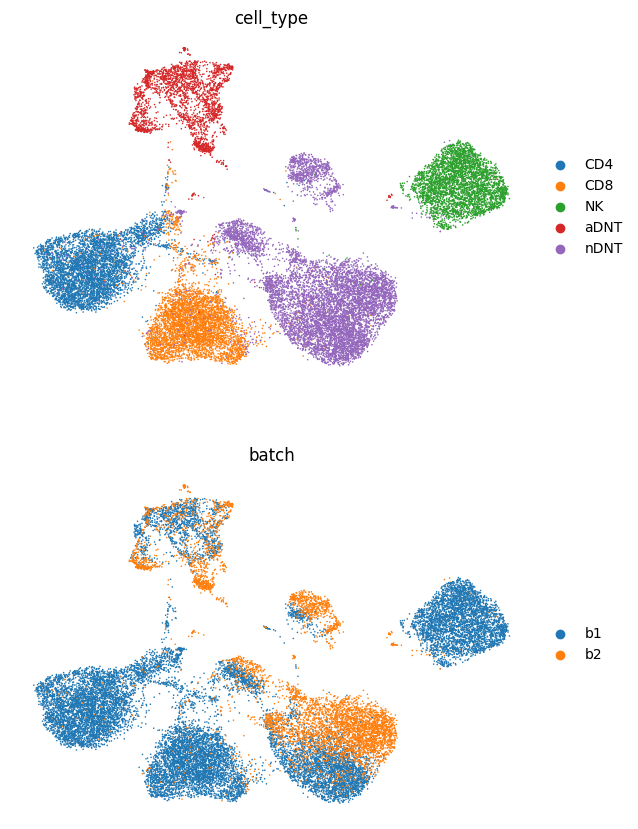

In [11]:
sc.pl.umap(adata,color=["cell_type",'batch'],frameon=False, ncols=1)
plt.show()

In [12]:
de = vae.differential_expression(adata,groupby='cell_type')

DE...: 100%|██████████| 5/5 [00:21<00:00,  4.40s/it]


In [13]:
def to_curly(gene: str) -> str:
    curly_gene = ("$" + gene + "$")
    return curly_gene

In [14]:
de_gene = de[
    (de['proba_de'] > 0.8) &
    (de['lfc_mean'] > 1) &
    (de['non_zeros_proportion1'] > 0.2)
]
de_gene = de_gene.sort_values('proba_de', ascending = False)
de_groups = de_gene.groupby('comparison')

markers = {
    name.split(' ')[0]: de_groups.get_group(name).index.tolist()[:5] for name in de_groups.groups.keys()
    }

symbols = []
for name in markers:
    symbols.extend(list(map(to_curly,markers[name])))

c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


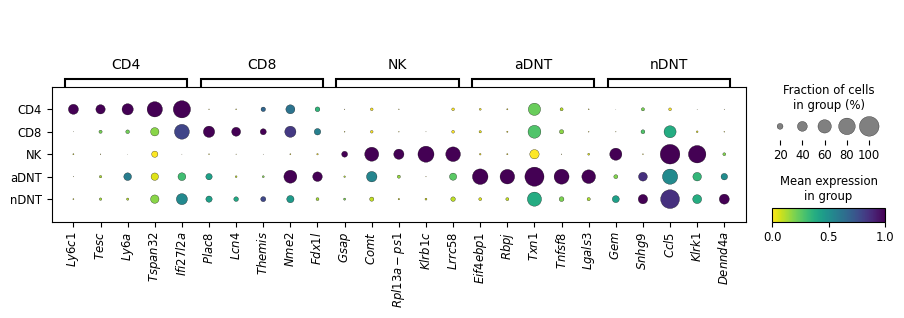

In [18]:
ax = sc.pl.dotplot(
    adata,
    markers,
    groupby='cell_type',
    use_raw=True,
    standard_scale='var',
    cmap=cm.viridis_r,
    show=False
    )

ax['mainplot_ax'].set_xticklabels(symbols)
plt.show()